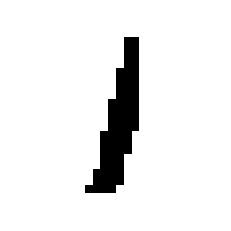

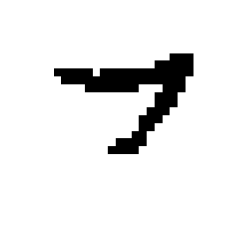

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 10.8 ms
CPU times: user 2.48 s, sys: 0 ns, total: 2.48 s
Wall time: 2.48 s


In [1]:
%run ../functions.ipynb ;

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
def learning_step(mps, index, imgs):
    
    Z = mps @ mps
    A = (mps.tensors[index] @ mps.tensors[index+1])
    
    for image in imgs:
        continue
    return A